In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import seaborn as sns

## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)

In [2]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    df_sums = df[["gene_id", "total_counts"]].groupby("gene_id").sum()
    
    df_sums["total_counts_gene"] = df_sums["total_counts"]

    df_sums.drop(columns="total_counts", inplace=True)
    
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    merged_df["relative_abundance_percent"] = ((merged_df["total_counts"]/merged_df["total_counts_gene"]) * 100)
    
    merged_df.drop(columns="total_counts", inplace=True)
    
    return merged_df

In [3]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split("source_gene=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split("source_transcript=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get CHM gene_ids
        df["CHM_gene_id"] = df["other"].str.split("gene_id=", expand=True)[1].str.split(';', expand=True)[0]

        ## Get transcript ids
        df["CHM_transcript_id"] = df["other"].str.split("transcript_id=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get transcript names
        df["transcript_name"] = df["other"].str.split("source_transcript_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("source_gene_common_name=", expand=True)[1].str.split(';', expand=True)[0]
        
        ## Get start codon
        df["start_codon"] = df["other"].str.split("adj_start=", expand=True)[1].str.split(";", expand=True)[0]
        
        ## Get stop codon
        df["stop_codon"] = df["other"].str.split("adj_stop=", expand=True)[1].str.split(";", expand=True)[0]        

        ## Only keep relevant
        df = df[["chr", "start", "end", "strand", "type", "gene_id", "transcript_id", "CHM_gene_id",
                 "CHM_transcript_id", "transcript_name", "gene_name", "start_codon", "stop_codon"]].copy()

        ## Drop duplicates
        df.drop_duplicates(inplace=True)
        

    else:

        ## Get CHM gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get CHM transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Label novel transcripts
        df.loc[df["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
        df.loc[~df["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

        ## Label novel genes
        df.loc[df["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
        df.loc[~df["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [4]:
'''
function name: merge_annotations

purpose: Merge useful/relevant information from both annotations while removing repeated and irrelevant information

input: Two different GTF annotations

output: One GTF annotation containing all the relevant information
'''

def merge_annotations(ref_gtf, bambu_gtf):
    
    ## Merge the two annotations
    names_ref_gtf = ref_gtf[["transcript_id", "gene_id", "gene_name", "transcript_name"]].copy()
    merged_gtf = pd.merge(bambu_gtf, names_ref_gtf, on=['gene_id', 'transcript_id'], how='left')
    merged_gtf.drop_duplicates(inplace=True)

    ## Label novel transcripts
    merged_gtf.loc[merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = True
    merged_gtf.loc[~merged_gtf["transcript_id"].str.startswith("tx."), "is_novel_transcript"] = False

    ## Label novel genes
    merged_gtf.loc[merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = True
    merged_gtf.loc[~merged_gtf["gene_id"].str.startswith("gene."), "is_novel_gene"] = False

    ## Create temporary variable only containing novel transcripts
    temp = merged_gtf.loc[merged_gtf["is_novel_transcript"] == True]

    ## Annotate novel transcripts
    merged_tmp = pd.merge(temp, ref_gtf[["gene_id", "gene_name"]], on=['gene_id'], how='left')
    merged_tmp.drop_duplicates(inplace=True)
    merged_tmp["gene_name"] = merged_tmp["gene_name_y"]
    merged_tmp.drop(columns=["source", "gene_name_y", "gene_name_x"], inplace=True)

    ## Return novel transcripts to original annotation
    merged_final = pd.merge(merged_gtf, merged_tmp, on=['chr', 'type', 'start', 'end', 'strand', 'transcript_id',
                    'transcript_name', 'gene_id', 'is_novel_transcript', 'is_novel_gene', 'exon_number'], how="left")

    ## Get gene names for novel transcripts of known genes
    merged_final.gene_name_x.fillna(merged_final.gene_name_y, inplace=True)
    merged_final["gene_name"] = merged_final["gene_name_x"]
    merged_final.drop(columns =["gene_name_x", "gene_name_y"], inplace=True)
    
    ## Get start and stop codons for known transcripts and exons of protein coding genes
    ref_gtf = ref_gtf[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "start_codon", "stop_codon"]]
    merged_final = pd.merge(merged_final, ref_gtf, on=["chr", "type", "start", "end", "strand", "transcript_id", "gene_id"], how="left")
    
    
    merged_final = merged_final[["chr", "type", "start", "end", "strand", "transcript_id", "gene_id", "gene_name", 
                    "exon_number", "transcript_name", "start_codon", "stop_codon", "is_novel_gene", "is_novel_transcript"]]


    
    return merged_final 

In [5]:
'''
name: make_gene_and_transcript_converter

input: The CHM13 CAT/Liftoff gff annotation version 2.0

output: A dataframe with ["gene_id", "transcript_id", "gene_name", "transcript_name"] formatted in the same way as the 
bambu reference, so that we can properly assign gene and transcript names.

purpose: Creating a list that allows us to assign transcript and gene names to the bambu annotation based on the transcript
id and gene ID
'''


def make_gene_and_transcript_converter(gff):
    
    ## Change name of duplicate Ensembl IDs to CHM IDs
    gff.loc[gff["transcript_id"] == "N/A", "transcript_id"] = gff["CHM_transcript_id"]
    gff_transcripts = gff.loc[gff["type"] == "transcript"].copy()
    gff_transcripts = gff_transcripts[["transcript_id", "CHM_transcript_id"]].drop_duplicates()
    gff_transcripts = gff_transcripts[gff_transcripts['transcript_id'].duplicated() == True]
    dup_trans = gff_transcripts["transcript_id"].dropna().values.tolist()
    gff.loc[gff["transcript_id"].isin(dup_trans), "transcript_id"] = gff["transcript_id"] + "(" + gff["CHM_transcript_id"] + ")"

    ## Change name of duplicate gene ids to CHM ids
    gff.loc[gff["gene_id"] == "None", "gene_id"] = gff["CHM_gene_id"]
    gff_genes = gff.loc[gff["type"] == "transcript"].copy()
    gff_genes = gff_genes[["gene_id", "CHM_gene_id"]].drop_duplicates()
    gff_genes = gff_genes[gff_genes['gene_id'].duplicated() == True]
    dup_genes = gff_genes["gene_id"].dropna().values.tolist()
    gff.loc[gff["gene_id"].isin(dup_genes), "gene_id"] = gff["gene_id"] + "(" + gff["CHM_gene_id"] + ")"

    
    ## Fix gene names for MSTRG Genes
    gff_names = gff.loc[gff["type"] == "transcript"].copy()
    gff_names = gff_names[["gene_id", "gene_name"]].copy()
    gff_names.loc[gff_names["gene_name"].str.contains("MSTRG."), "gene_name"] = np.NaN
    gff_names.dropna(inplace=True)
    gff_names.drop_duplicates(inplace=True, subset=["gene_id"])
    gff.drop(columns="gene_name", inplace=True)
    gff = pd.merge(gff, gff_names, on="gene_id", how="left")
    gff = gff[["gene_id", "transcript_id", "gene_name", "transcript_name",
              "start", "end", "type", "start_codon", "stop_codon", "chr", "strand"]].copy()


    return gff

In [6]:
## Fix column names in counts matrix

chm13_counts = pd.read_csv("../../data/novel_genes/bambu_discovery_sfn/counts_transcript.txt", delimiter="\t", low_memory=False, 
                           header=0)

new_col_names = []
for col in chm13_counts.columns:
        new_col_names.append(col.split("_nanopore")[0])
        
chm13_counts.columns = new_col_names

In [7]:
## Find novel transcripts in both annotations
chm13_counts.loc[chm13_counts["TXNAME"].str.startswith("tx."), "is_novel_transcript"] = True
chm13_counts.loc[~chm13_counts["TXNAME"].str.startswith("tx."), "is_novel_transcript"] = False

## Find novel genes in both annotations
chm13_counts.loc[chm13_counts["GENEID"].str.startswith("gene."), "is_novel_gene"] = True
chm13_counts.loc[~chm13_counts["GENEID"].str.startswith("gene."), "is_novel_gene"] = False

In [8]:
## Create dataframes with either only novel genes or only novel transcripts that are not from novel genes
chm13_novel_genes = chm13_counts.loc[chm13_counts["is_novel_gene"]].copy()
chm13_novel_transcripts = chm13_counts.loc[((chm13_counts["is_novel_transcript"]) & (~chm13_counts["is_novel_gene"]))].copy()

In [9]:
## See how many novel genes
print("We found", chm13_novel_genes.shape[0], "novel genes in CHM13")

We found 171 novel genes in CHM13


In [10]:
## Filter novel genes and transcripts, must be present in at least three samples with 50+ counts.
count_cols = chm13_novel_genes.columns[2:6].tolist()
chm13_novel_genes = chm13_novel_genes[(chm13_novel_genes[count_cols]>10).sum(axis=1)>=4]
chm13_novel_transcripts = chm13_novel_transcripts[(chm13_novel_transcripts[count_cols]>10).sum(axis=1)>=4]

In [11]:
## Count number of novel genes and novel transcripts in each dataframe
print("We found", chm13_novel_genes.shape[0], "novel genes in CHM13")
print("We found", chm13_novel_transcripts.shape[0], "novel transcripts of known genes in CHM13")

We found 88 novel genes in CHM13
We found 541 novel transcripts of known genes in CHM13


In [12]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
chm13_ref = pd.read_csv("../../data/novel_genes/bambu_discovery_sfn/extended_annotations.gtf", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])


chm13_ref = parse_df_columns(chm13_ref, is_ref=False)

In [13]:
## "Fix" gene_id
chm13_ref["gene_id"] = chm13_ref["gene_id"].str.split(".", expand=True)[0]

In [14]:
## Only keep transcripts
chm13_ref = chm13_ref.loc[chm13_ref["type"] == "transcript"]

In [15]:
## Only keep expressed transcripts
chm13_novel_transcripts_expressed = chm13_ref.loc[chm13_ref["transcript_id"].isin(chm13_novel_transcripts["TXNAME"])].copy()

In [16]:
## Import disease relevant genes
disease_relevant_genes = pd.read_csv("../../../cDNA-comparison/article_analysis/annotations/disease_relevant_gene_names.csv", names=["gene_id", "gene_name"],
                                    header=0)
## Ad genes
ad_names = pd.read_csv("../../data/novel_genes/AD_genes.csv", sep="\t")
ad_names.dropna(inplace=True)
ad_names.drop_duplicates(inplace=True)

## Concatenate both
disease_relevant_genes = pd.concat([disease_relevant_genes, ad_names]).drop_duplicates()


In [17]:
## Save novel transcript in known genes for GRCh38 so that we can compare them to known trancripts in ENSEMBL tracks
orig_ref = pd.read_csv("../../../cDNA-comparison/article_analysis/annotations/CHM13.v2.0.gff3", header=None, delimiter="\t",
                        low_memory=False, names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"])



In [18]:
## Create good reference to convert gene names
orig_ref = parse_df_columns(orig_ref, is_ref=True)
orig_ref = orig_ref.loc[orig_ref["type"]=="gene"].copy()

## Take the extra stuff for the version of genes on ENSEMBL ID
orig_ref["gene_id"] = orig_ref["gene_id"].str.split(".", expand=True)[0].copy()

In [19]:
## Create list of novel transcripts in disease relevant genes
novel_relevant = disease_relevant_genes.merge(orig_ref[["gene_id", "gene_name"]], on=["gene_id", "gene_name"], how="inner")

In [20]:
## Only keep gene_ids that match, add gene names
novel_relevant = chm13_novel_transcripts_expressed.merge(novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [21]:
## Drop any duplicates
novel_relevant.drop_duplicates(inplace=True)

In [22]:
## See shape
novel_relevant.shape

(63, 12)

In [23]:
## Only keep original ensembl ID
chm13_counts["gene_id"] = chm13_counts["GENEID"].str.split(".", expand=True)[0]

In [24]:
## Get total counts for each transcript
chm13_counts["total_counts"] = chm13_counts[count_cols].sum(axis=1)

In [25]:
## Merge with medically relevant genes on gene_id and get gene names
novel_relevant_counts = pd.merge(chm13_counts, novel_relevant[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [26]:
## Drop any duplicates
novel_relevant_counts.drop_duplicates(inplace=True)

In [27]:
## See shape
novel_relevant_counts.shape

(763, 11)

In [28]:
novel_relevant_counts.loc[novel_relevant_counts["is_novel_transcript"]==True].shape

(64, 11)

In [29]:
## Calculate relative transcript abundance
novel_relevant_relative_abundance = relative_transcript_abundance(novel_relevant_counts)

In [45]:
## Create list with med relevant genes with novel isoforms and their relative frequency
novel_relevant_words = novel_relevant_relative_abundance.loc[novel_relevant_relative_abundance["is_novel_transcript"] == True][["gene_name", "relative_abundance_percent"]]

In [46]:
## Drop duplicates
novel_relevant_words = novel_relevant_words.drop_duplicates()

In [47]:
## Sum relative abundance of all novel isoforms by gene name and round to nearest integer
novel_relevant_words = round(novel_relevant_words.groupby("gene_name")["relative_abundance_percent"].sum(), 0)

In [48]:
## Create a dataframe to properly store the data
novel_relevant_word_df = pd.DataFrame()
novel_relevant_word_df['word_count'] = novel_relevant_words
novel_relevant_word_df["gene_name"] = novel_relevant_words.index

In [49]:
## Drop index
novel_relevant_word_df.reset_index(inplace=True, drop=True)

In [50]:
## Print genes with novel isoforms relevant to AD
ad_names = pd.read_csv("../../data/novel_genes/AD_genes.csv", sep="\t")
print(novel_relevant_word_df.loc[novel_relevant_word_df["gene_name"].isin(ad_names["gene_name"])])

    word_count gene_name
22        40.0  HLA-DQA1
23        65.0      IDUA


In [51]:
## Print relative abundance for a couple other genes
print(novel_relevant_word_df.loc[novel_relevant_word_df["gene_name"].isin(["MAOB", "SLC26A1"])])

    word_count gene_name
28         8.0      MAOB
45        92.0   SLC26A1


In [89]:
novel_relevant_word_df

,word_count,gene_name
0,30.0,ABO
1,15.0,ACADM
2,20.0,ALAD
3,75.0,ALDH1A1
4,7.0,ALG11
5,46.0,ALG3
6,30.0,BCAN
7,68.0,CA5A
8,72.0,CAMKMT
9,25.0,CAST


In [52]:
## Print number of disease relevant genes with high-confidence novel isoforms
novel_relevant_word_df["gene_name"].nunique()

61

In [53]:
## Generate word list with frequency of word being proportional to novel isoform relative abundance
word_list = ""

for i in range(len(novel_relevant_word_df)):
        
    for j in range(int(novel_relevant_word_df.iloc[i][0])):
        word_list = word_list + novel_relevant_word_df.iloc[i][1] + " "
        

In [54]:
## Generate wordcloud
word_cloud = WordCloud(collocations=False, font_step=1, background_color='white', regexp=r"\w[\w\-]+", normalize_plurals=False,
            colormap="nipy_spectral", prefer_horizontal=1, include_numbers=True, stopwords=None, random_state=1996,
                      width=15000, height=12000).generate(word_list)

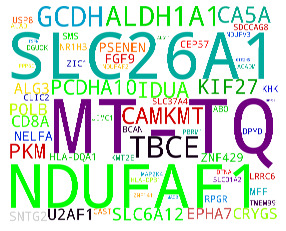

In [55]:
## Save the online poster version (lower DPI)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../../figures/AAIC_figures/word_cloud_online.png', dpi=92, transparent=True, bbox_inches="tight")
plt.show()

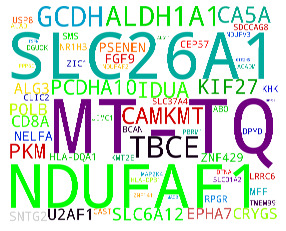

In [56]:
## Save the in-person poster version (higher DPI) 
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('../../figures/AAIC_figures/word_cloud_in-person.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

In [57]:
## Take the extra stuff for the version of genes on ENSEMBL ID
chm13_counts["GENEID"] = chm13_counts["GENEID"].str.split(".", expand=True)[0].copy()

In [58]:
## Change the column names, GENEID to gene_id
chm13_counts["gene_id"] = chm13_counts["GENEID"].copy()
chm13_counts.drop(columns="GENEID", inplace=True)

In [59]:
## Only keep gene_ids that match between both
chm13_counts_with_name = chm13_counts.merge(orig_ref[["gene_id", "gene_name"]], on=["gene_id"], how="inner")

In [60]:
## Drop any duplicates
chm13_counts_with_name.drop_duplicates(inplace=True)

In [61]:
## Get the gene names in the counts matrix and only keep medically relevant genes
medically_relevant_counts = chm13_counts_with_name.merge(disease_relevant_genes[["gene_id", "gene_name"]], on=["gene_id", "gene_name"], how="inner")

In [62]:
## Delete duplicates
medically_relevant_counts.drop_duplicates(inplace=True)

In [63]:
## Remove all isoforms with less than 500 reads in every sample
medically_relevant_counts = medically_relevant_counts[(medically_relevant_counts[count_cols]>100).sum(axis=1)>=4].copy()

In [64]:
## Only keep genes with more than one "highly expressed" isoforms
dup_gene_names = medically_relevant_counts.loc[medically_relevant_counts.duplicated(subset="gene_id")]

medically_relevant_counts_multiple_iso = medically_relevant_counts.loc[medically_relevant_counts["gene_id"].isin(dup_gene_names["gene_id"])].copy()

In [65]:
## How many medically relevant isoforms with more than one highly expressed isoforms in one gene
medically_relevant_counts_multiple_iso.shape

(1492, 10)

In [66]:
## How many highly expressed isoforms are there for each gene?
df_numbers = medically_relevant_counts_multiple_iso["gene_id"].value_counts()

In [67]:
## How many medically relevant genes have more than one highly expressed isoform?
medically_relevant_counts_multiple_iso["gene_id"].nunique()

615

In [68]:
## Display their names
medically_relevant_counts_multiple_iso["gene_name"].unique()

array(['BCAN', 'KHK', 'DGUOK', 'MFF', 'ALG3', 'NDUFAF2', 'CAST',
       'PCDHA10', 'HLA-DPB1', 'GTF2H5', 'KMT2E', 'POLB', 'ALDH1A1',
       'ALAD', 'USP8', 'SNAPC5', 'PKM', 'SULT1A1', 'MAP2K4', 'DTNA',
       'ZNF429', 'PSENEN', 'NDUFV3', 'U2AF1', 'SMS', 'MAOB', 'MT-TQ',
       'IVD', 'TGFBR3', 'PDE4DIP', 'ATP2B4', 'ANK3', 'SHTN1', 'CPT1A',
       'SLC11A2', 'ZDHHC17', 'UBE3B', 'ATP2A2', 'MED13L', 'GOLGA3', 'NIN',
       'KTN1', 'HSP90AA1', 'TCF12', 'MEF2A', 'ABR', 'PAFAH1B1', 'LASP1',
       'TRIM37', 'LPIN2', 'FBXO11', 'SPTBN1', 'XPO1', 'SPRED2', 'ATF2',
       'SF3B1', 'SIRPA', 'RIN2', 'TGM2', 'STK4', 'DYRK1A', 'SREBF2',
       'MYLK', 'KIAA0232', 'TRIO', 'IL6ST', 'SYNPO', 'SOD2', 'TNS3',
       'TRRAP', 'KMT2C', 'CTSB', 'HNRNPK', 'SPTAN1', 'SETX', 'UBA1',
       'HUWE1', 'PGK1', 'LAMP2', 'OCRL', 'HCFC1', 'CD74', 'ERCC1',
       'GABRA1', 'RB1CC1', 'DCN', 'KCNAB2', 'KEAP1', 'ALDH3A2', 'SLC25A3',
       'DLG3', 'MAP2', 'EPB41L1', 'SPG21', 'TECR', 'XBP1', 'SYNGR1',
       'CHGA', 'APE

In [69]:
## Display number of isoforms for key genes I am interested in
medically_relevant_counts_multiple_iso.loc[medically_relevant_counts_multiple_iso["gene_name"].isin(["MAPT", "APP", "SNCA", "PARK7", "PINK1"])]["gene_name"].value_counts()

SNCA     4
APP      4
MAPT     3
PINK1    2
PARK7    2
Name: gene_name, dtype: int64

In [70]:
## Display number of isoforms for key genes I am interested in
medically_relevant_counts_multiple_iso.loc[medically_relevant_counts_multiple_iso["gene_id"].isin(ad_names["gene_id"])]["gene_name"].value_counts()

CTSB     6
APP      4
BIN1     3
TNIP1    3
CLU      3
ANK3     2
COX7C    2
JAZF1    2
Name: gene_name, dtype: int64

In [71]:
## Display number of isoforms for key genes for all
medically_relevant_counts_multiple_iso["gene_name"].value_counts()

SNRPN         7
ANK2          7
GNAS          7
DTNA          7
CTSB          6
ACTB          6
CRYAB         6
HNRNPK        5
BSCL2         5
HNRNPA2B1     5
FDPS          5
SPTAN1        5
RPS24         5
PDE4DIP       5
SLC25A3       5
UQCRQ         5
CHN1          5
MFF           5
COX4I1        5
ALDOA         5
NTRK2         4
ERCC1         4
MAX           4
SYNE1         4
SNCA          4
SOD2          4
EIF4A2        4
DST           4
EEF1B2        4
PPP3CA        4
GRHPR         4
MFN2          4
BANF1         4
GLUL          4
QKI           4
RPL38         4
HDLBP         4
KCNAB2        4
ADD1          4
CAMTA1        4
SMARCA2       4
TUBA1A        4
SPTBN1        4
CALM3         4
KIF5A         4
NEFM          4
CALM2         4
FTH1          4
APP           4
BCAN          4
KLC1          4
HLA-A         4
MATR3         4
DNAJC19       4
DCTN1         4
NACA          4
PSIP1         4
PKM           4
CNBP          4
CCND3         4
STXBP1        4
CTNNB1        4
DGUOK   

In [72]:
## How many highly expressed isoforms are there for each gene?
df_numbers = medically_relevant_counts_multiple_iso["gene_name"].value_counts()

In [73]:
medically_relevant_counts_multiple_iso['Number of Isoforms'] = medically_relevant_counts_multiple_iso['gene_id'].copy().map(medically_relevant_counts_multiple_iso['gene_id'].value_counts())

In [74]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams.update({'font.size': 28})
rcParams['axes.linewidth'] = 6

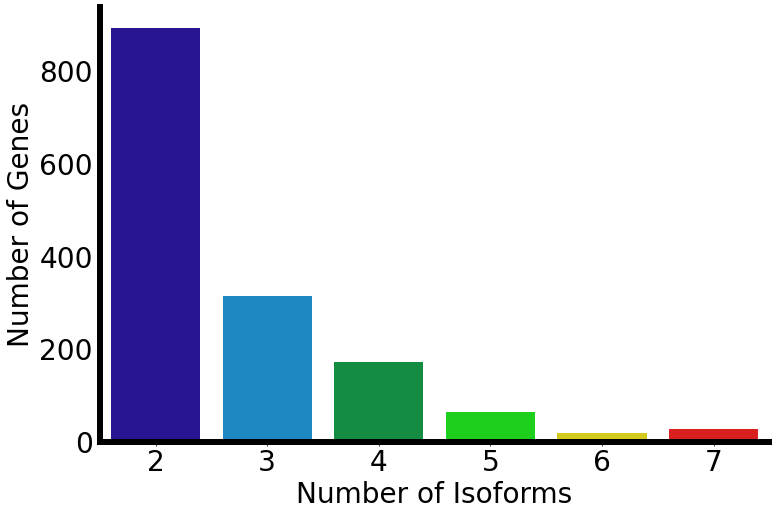

In [75]:
sns.countplot(x="Number of Isoforms", data=medically_relevant_counts_multiple_iso, palette="nipy_spectral")
sns.despine()
plt.ylabel("Number of Genes")
plt.savefig('../../figures/AAIC_figures/multiple_isoforms_in-person.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

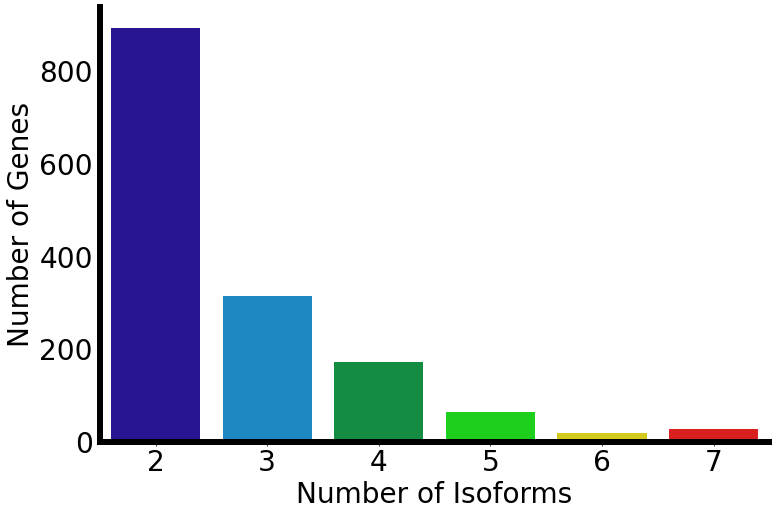

In [76]:
sns.countplot(x="Number of Isoforms", data=medically_relevant_counts_multiple_iso, palette="nipy_spectral")
sns.despine()
plt.ylabel("Number of Genes")
plt.savefig('../../figures/AAIC_figures/multiple_isoforms_online.png', dpi=92, transparent=True, bbox_inches="tight")
plt.show()

In [77]:
exclusive_chm13 = pd.read_csv("../../data/novel_genes/CHM13_novel_genes_isoseq.csv")

In [78]:
exclusive_chm13.head()

,GENEID
0,CHM13_G0002360
1,CHM13_G0002906
2,CHM13_G0003812
3,CHM13_G0006285
4,CHM13_G0007830


In [79]:
exclusive_chm13_counts = chm13_counts.loc[chm13_counts["gene_id"].isin(exclusive_chm13['GENEID'])]

In [80]:
exclusive_chm13_counts["GENEID"] = exclusive_chm13_counts["gene_id"]

exclusive_chm13_counts.drop(columns=["is_novel_gene", "is_novel_transcript", "total_counts", "gene_id"], inplace=True)

exclusive_chm13_counts["Label"] = "T2T New Genes"


C:\Users\bag22\AppData\Local\Temp\ipykernel_10380\3043105235.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclusive_chm13_counts["GENEID"] = exclusive_chm13_counts["gene_id"]
C:\Users\bag22\AppData\Local\Temp\ipykernel_10380\3043105235.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclusive_chm13_counts.drop(columns=["is_novel_gene", "is_novel_transcript", "total_counts", "gene_id"], inplace=True)
C:\Users\bag22\AppData\Local\Temp\ipykernel_10380\3043105235.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [81]:
chm13_novel_genes.drop(columns=["is_novel_transcript", "is_novel_gene"], inplace=True)

chm13_novel_genes["Label"] = ""

In [82]:
exclusive_chm13_counts = exclusive_chm13_counts[['TXNAME', 'GENEID', 'sample_PAM54788', 'sample_PAM54335', 'sample_PAM54401',
       'sample_PAM54902', 'Label']]

In [83]:
all_novel_genes = pd.concat([chm13_novel_genes, exclusive_chm13_counts])

In [84]:
all_novel_genes = all_novel_genes[(all_novel_genes[count_cols]>10).sum(axis=1)>=4]

In [85]:
all_novel_genes.shape

(96, 7)

In [86]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 8,12
rcParams.update({'font.size': 28})
rcParams['axes.linewidth'] = 6

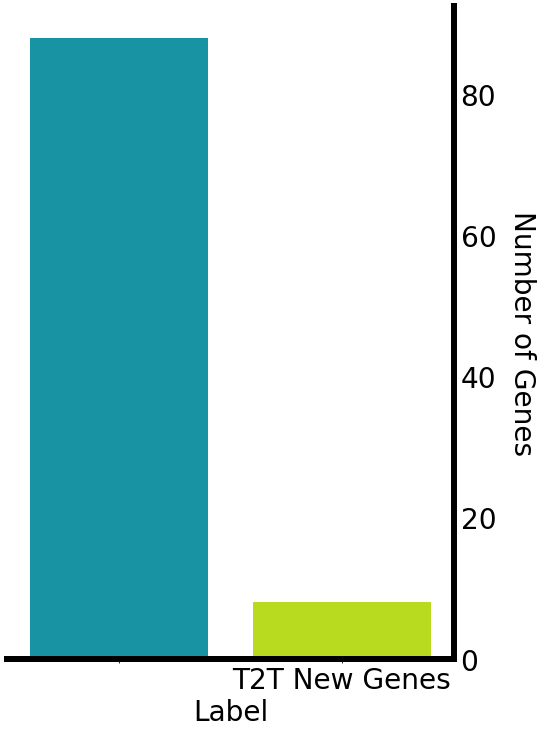

In [87]:
fig, ax1 = plt.subplots()
ax1.yaxis.set_ticks_position("right")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

sns.countplot(x="Label", data=all_novel_genes, palette="nipy_spectral", ax=ax1)

plt.ylabel("Number of Genes", rotation=270, labelpad=40)
plt.xlabel("Label", labelpad=4)
sns.despine(right=False, left=True, top=True, bottom=False)

plt.savefig('../../figures/AAIC_figures/novel_genes_in-person.png', dpi=300, transparent=True, bbox_inches="tight")
plt.show()

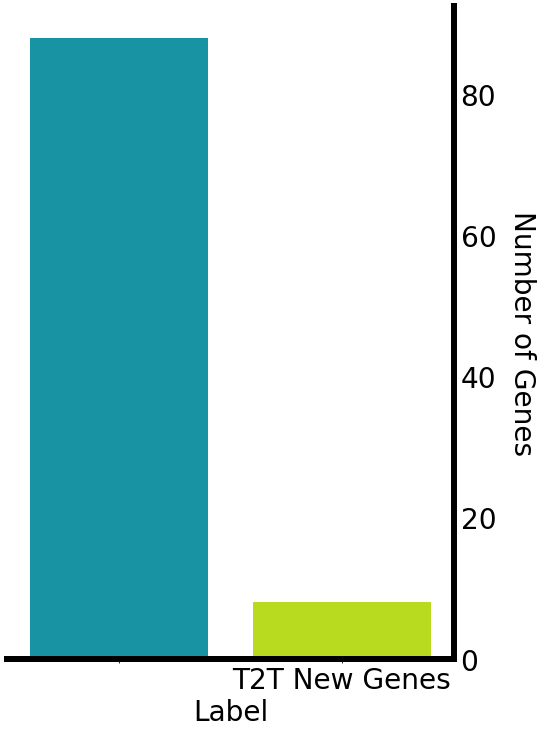

In [88]:
fig, ax1 = plt.subplots()
ax1.yaxis.set_ticks_position("right")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

sns.countplot(x="Label", data=all_novel_genes, palette="nipy_spectral", ax=ax1)

plt.ylabel("Number of Genes", rotation=270, labelpad=40)
plt.xlabel("Label", labelpad=4)
sns.despine(right=False, left=True, top=True, bottom=False)

plt.savefig('../../figures/AAIC_figures/novel_genes_online.png', dpi=92, transparent=True, bbox_inches="tight")
plt.show()